<a href="https://colab.research.google.com/github/Mtlukasik/PyroNotebooks/blob/main/BasicProbModelsPyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade pyro-ppl torch graphviz
import pyro
import torch
import pyro.distributions as dist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 12.1 MB/s eta 0:00:00


# 1. **Pyro’s models** (http://pyro.ai/examples/intro_part_i.html) :


* In Pyro, a probabilistic model is defined as a **stochastic function** (i.e. every time it is run, it returns a new sample).

* Each random variable is associated with a **primitive stochastic function** using the construct ``pyro.sample(...)``.


### 1.1 A Temperature Model



As initial running example, we consider the problem of **modelling the temperature**. We first start with a simple model, where temperture is modeled using a random Normal variable.

The above method defines a joint probability distribution:
$$p(sensor, temp) = p(sensor|temp)p(temp)$$
$$p(temp) = \mathcal{N}(\mu=15,\,\sigma^{2}=2^2)$$
$$p(sensor|temp) = \mathcal{N}(\mu=temp,\,\sigma^{2}=1^2)$$


tensor(14.1796)
tensor(12.6851)


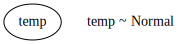

In [ ]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    return temp

print(model())
print(model())
# Visualize the model
pyro.render_model(model, render_distributions=True)

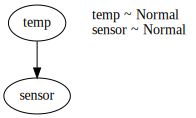

In [ ]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0))
    return (temp, sensor)

# Visualize the model
pyro.render_model(model, render_distributions=True)

####Prior predictive checks

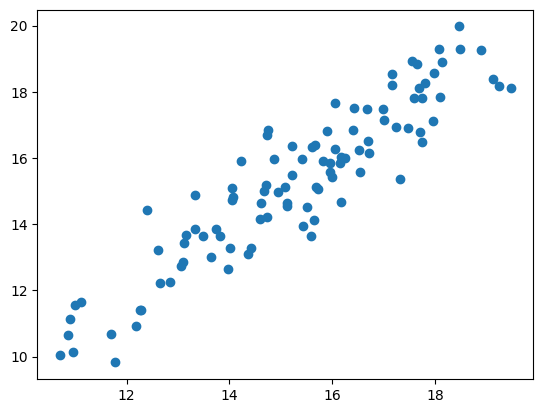

In [ ]:
import matplotlib.pyplot as plt
tensor_list = [model() for i in range(100)]
value_list = list(map(lambda x: tuple(map(lambda y: y.item(), x)), tensor_list))
plt.scatter(torch.tensor(value_list)[:,0],torch.tensor(value_list)[:,1])
plt.show()

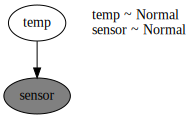

In [ ]:
#The observatons
obs = {'sensor': torch.tensor(18.0)}

def model(obs):
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 0.1), obs=obs['sensor'])
pyro.render_model(model, model_args=(obs, ), render_distributions=True)

$$p(temp | sensor=18)=\frac{p(sensor=18|temp)p(temp)}{\int p(sensor=18|temp)p(temp) dtemp}$$

Step: 0. ELBO: -16147.421896100044
Step: 100. ELBO: -5.638109087944031
Step: 200. ELBO: -2.748673915863037
Step: 300. ELBO: -2.5427181720733643
Step: 400. ELBO: -2.9723092317581177


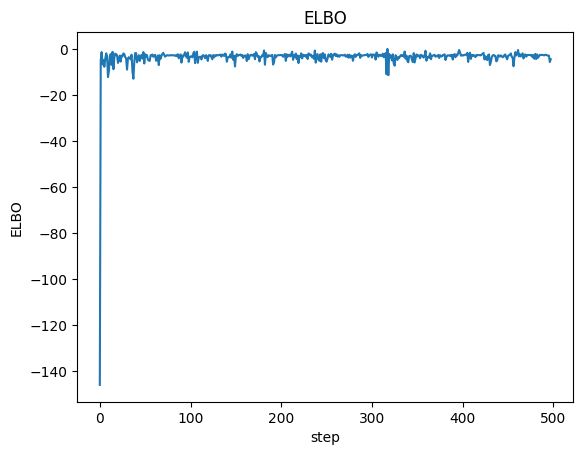

P(Temperature|Sensor=18.0) = 
Normal(loc: 18.043657302856445, scale: 0.11020330339670181)



In [ ]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoNormal
def svi(model, obs, guide=None, num_steps = 500, plot = False, verbose=False, lr=0.01):

    torch.manual_seed(999)

    pyro.clear_param_store() # why this

    if guide is None:
        guide = AutoNormal(model)

    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         optim=SGD({"lr": lr, "momentum":0.1}),
                         loss=Trace_ELBO())

    elbo, a,b  = [], [], []

    for t in range(num_steps):
        elbo.append(-svi.step(obs))
        if t%100==0:
            print('Step: '+str(t)+'. ELBO: ' +str(elbo[-1]))


    if (plot):
        plt.plot(elbo[2:])
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("ELBO");
        plt.show()

    if verbose:
        print("Inference results:")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name).item())
    return guide
#Run inference
guide = svi(model,obs, plot=True)
#Print results
print("P(Temperature|Sensor=18.0) = ")
print(dist.Normal(pyro.param("AutoNormal.locs.temp").item(), pyro.param("AutoNormal.scales.temp").item()))
print("")

In [ ]:
# Number of samples you want to generate
num_samples = 100

temp_samples_tensor = torch.tensor([guide()['temp'].detach().item() for _ in range(num_samples)])

# Now feed these back into the model to get sensor samples
sensor_samples_tensor = torch.tensor([pyro.sample('sensor', dist.Normal(temp, 0.1)) for temp in temp_samples_tensor])

# Stack them together to form a 2D tensor
samples_matrix = torch.stack((temp_samples_tensor, sensor_samples_tensor))

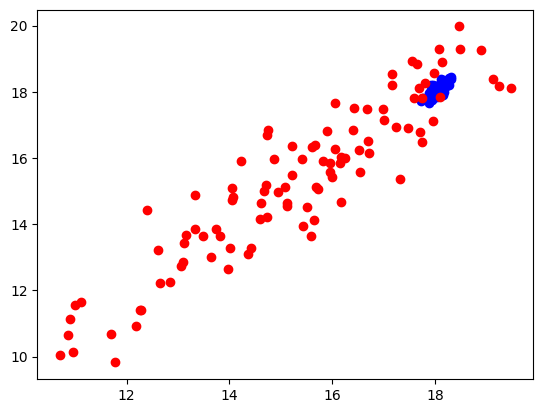

In [ ]:
plt.scatter(samples_matrix[0],samples_matrix[1],c='b')
plt.scatter(torch.tensor(value_list)[:,0],torch.tensor(value_list)[:,1],c='r')

Step: 0. ELBO: -2270.0551319122314
Step: 100. ELBO: -191.25132358074188
Step: 200. ELBO: -55.761174857616425
Step: 300. ELBO: -42.96208891272545
Step: 400. ELBO: -40.83998817205429


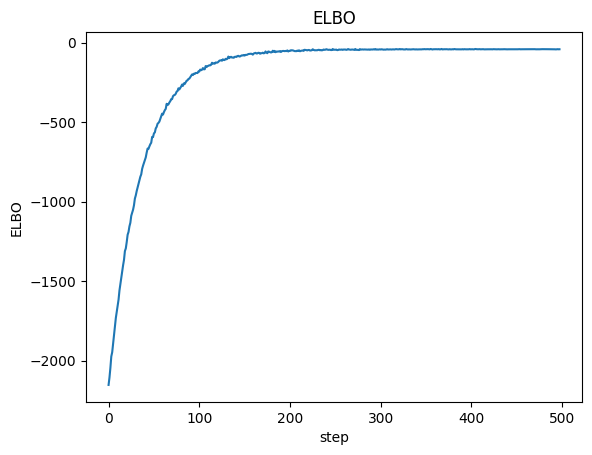

Inference results:
AutoNormal.locs.temp_0 17.427947998046875
AutoNormal.scales.temp_0 0.8459584712982178
AutoNormal.locs.temp_1 17.941848754882812
AutoNormal.scales.temp_1 0.8458547592163086
AutoNormal.locs.temp_2 18.27560806274414
AutoNormal.scales.temp_2 0.8490453958511353
AutoNormal.locs.temp_3 17.2302303314209
AutoNormal.scales.temp_3 0.902186930179596
AutoNormal.locs.temp_4 19.30435562133789
AutoNormal.scales.temp_4 0.7995322346687317
AutoNormal.locs.temp_5 20.94558334350586
AutoNormal.scales.temp_5 0.9167338013648987
AutoNormal.locs.temp_6 19.312156677246094
AutoNormal.scales.temp_6 0.8623718619346619
AutoNormal.locs.temp_7 19.935022354125977
AutoNormal.scales.temp_7 0.8151288032531738
AutoNormal.locs.temp_8 18.566059112548828
AutoNormal.scales.temp_8 0.8957094550132751
AutoNormal.locs.temp_9 19.039104461669922
AutoNormal.scales.temp_9 0.8311464786529541


In [29]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(15.0, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
#Run inference
guide = svi(model, obs, verbose=True,plot=True)
num_samples = 100



In [30]:
guide()

{'temp_0': tensor(16.2739, grad_fn=<ExpandBackward0>),
 'temp_1': tensor(16.9504, grad_fn=<ExpandBackward0>),
 'temp_2': tensor(17.8525, grad_fn=<ExpandBackward0>),
 'temp_3': tensor(17.8268, grad_fn=<ExpandBackward0>),
 'temp_4': tensor(18.7155, grad_fn=<ExpandBackward0>),
 'temp_5': tensor(20.7751, grad_fn=<ExpandBackward0>),
 'temp_6': tensor(18.1410, grad_fn=<ExpandBackward0>),
 'temp_7': tensor(19.4948, grad_fn=<ExpandBackward0>),
 'temp_8': tensor(17.7748, grad_fn=<ExpandBackward0>),
 'temp_9': tensor(19.8493, grad_fn=<ExpandBackward0>)}

In [31]:
# Number of samples you want to generate
num_samples = 10

# Sample from the guide
temp_samples_dict = [guide() for _ in range(num_samples)]

# Initialize a dictionary to hold the corresponding sensor samples
sensor_samples_dict = {key: [] for key in temp_samples_dict[0].keys()}

# Now feed these back into the model to get sensor samples
for temp_samples in temp_samples_dict:
    for key, temp in temp_samples.items():
        sensor_samples_dict[key].append(pyro.sample('sensor', dist.Normal(temp.detach().item(), 0.1)).item())

# Convert lists to tensors
for key in sensor_samples_dict.keys():
    sensor_samples_dict[key] = torch.tensor(sensor_samples_dict[key])
temp_samples_tensor = torch.stack([torch.tensor([sample[key].detach().item() for key in sample.keys()]) for sample in temp_samples_dict])
temp_samples_tensor = temp_samples_tensor.flatten()
sensor_samples_tensor = torch.stack([sensor_samples_dict[key] for key in sensor_samples_dict.keys()]).flatten()



In [32]:
sensor_samples_tensor,temp_samples_tensor

(tensor([17.9555, 18.0351, 16.2295, 18.1713, 16.6736, 18.3429, 17.7042, 17.0499,
         16.4732, 17.5625, 16.8267, 17.7859, 18.6669, 18.4151, 18.8692, 17.1857,
         17.3845, 17.0640, 17.5125, 17.2556, 16.7796, 18.2989, 18.5775, 17.4128,
         19.2864, 17.8594, 17.1127, 17.4007, 18.0066, 17.3417, 16.8867, 17.2909,
         16.6072, 16.0890, 17.5404, 18.5961, 16.5776, 17.3452, 17.3346, 16.7893,
         20.6585, 20.2848, 19.0967, 19.4139, 18.4319, 19.2480, 20.2225, 19.7694,
         20.1697, 19.1768, 20.1228, 22.0056, 20.7738, 20.0523, 21.1286, 20.0107,
         21.4706, 21.7131, 21.2116, 21.6858, 19.4472, 18.6398, 17.0391, 18.5757,
         19.6683, 17.6899, 19.3099, 20.4361, 19.6023, 18.6533, 20.3219, 20.4988,
         19.6405, 18.3958, 21.1155, 19.6495, 19.6633, 19.8729, 20.2509, 21.2255,
         19.4868, 17.8174, 18.4160, 18.6775, 17.3710, 16.6112, 16.9989, 17.9706,
         18.3172, 18.6212, 18.4522, 19.4241, 19.3240, 19.0266, 19.9953, 18.3086,
         17.4118, 18.7261, 1

In [36]:
for i in range(0,10):
  print('temp')
  print(dist.Normal(pyro.param("AutoNormal.locs.temp_{}".format(i)).item(), pyro.param("AutoNormal.scales.temp_{}".format(i)).item()))

print("")

temp
Normal(loc: 17.427947998046875, scale: 0.8459584712982178)
temp
Normal(loc: 17.941848754882812, scale: 0.8458547592163086)
temp
Normal(loc: 18.27560806274414, scale: 0.8490453958511353)
temp
Normal(loc: 17.2302303314209, scale: 0.902186930179596)
temp
Normal(loc: 19.30435562133789, scale: 0.7995322346687317)
temp
Normal(loc: 20.94558334350586, scale: 0.9167338013648987)
temp
Normal(loc: 19.312156677246094, scale: 0.8623718619346619)
temp
Normal(loc: 19.935022354125977, scale: 0.8151288032531738)
temp
Normal(loc: 18.566059112548828, scale: 0.8957094550132751)
temp
Normal(loc: 19.039104461669922, scale: 0.8311464786529541)



####Posterior predictive checks

In [15]:
from pyro.infer import Predictive


# Initialize the Predictive class
predictive = Predictive(model, guide=guide, num_samples=1)

# Now we can sample from the predictive distribution
samples = predictive(obs)

temp_keys = [key for key in samples.keys() if key.startswith('temp')]

# Extract the corresponding temp samples and concatenate them into a tensor
temp_samples_all = torch.cat([samples[key] for key in temp_keys])



In [25]:
samples

tensor([[17.8507, 16.9249, 16.8095, 16.9003, 20.7276, 20.0571, 19.4429, 20.3187,
         19.3745, 18.3622, 18.0270, 17.7099, 18.2469, 17.2056, 20.3840, 22.0500,
         18.7060, 20.4969, 17.7795, 19.3592, 16.1820, 18.6248, 18.6516, 16.5707,
         19.2546, 20.7973, 17.0836, 19.6462, 18.3613, 19.3773, 18.1526, 18.4083,
         17.5136, 16.1795, 19.4076, 20.1587, 18.5591, 18.5791, 18.6943, 19.0694,
         16.6521, 18.8940, 19.3907, 17.5378, 18.4023, 21.0927, 19.7346, 21.1786,
         17.2435, 20.0663, 18.1890, 17.1504, 17.8981, 18.5689, 19.3458, 20.0066,
         17.6649, 19.6924, 16.7209, 18.4270, 17.6850, 17.3827, 17.1742, 16.6468,
         20.4099, 21.4629, 19.4010, 19.7432, 16.9419, 17.5017, 17.0740, 17.1488,
         17.4881, 17.2157, 19.8886, 21.6096, 20.4126, 19.7424, 18.0097, 18.7689,
         16.4322, 17.6822, 17.9666, 17.3971, 20.2553, 21.2221, 19.5840, 20.2480,
         18.3825, 19.0081, 17.6107, 17.1963, 17.3098, 16.7832, 19.2390, 21.6075,
         18.6036, 21.2753, 1

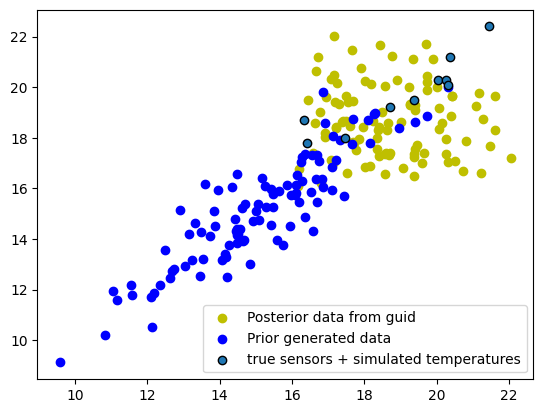

In [27]:
samples = torch.stack((temp_samples_tensor,sensor_samples_tensor))
plt.scatter(temp_samples_tensor,sensor_samples_tensor,c='y',label='Posterior data from guid')
plt.scatter(torch.tensor(value_list)[:,0],torch.tensor(value_list)[:,1],c='b',label= 'Prior generated data')
plt.scatter(temp_samples_all,obs['sensor'].detach(),label = 'true sensors + simulated temperatures',edgecolors='black')
plt.legend()

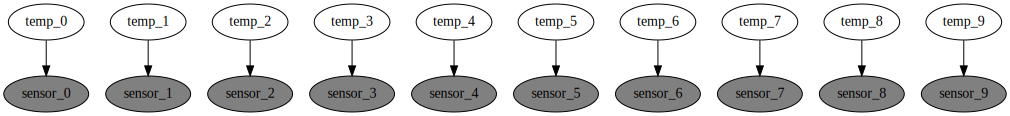

In [37]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

What if we do **not know the mean temperature**?

* We can **infer it from the data** by, e.g., using a **maximum likelihood** approach,
$$ \mu_{t} = \arg\max_\mu \ln p(s_1,\ldots,s_n|\mu) = \arg\max_\mu \ln \prod_i \int_{t_i} p(s_i|t_i)p(t_i|\mu) dt_i, $$ where $s_i$ and $t_i$ denote the sensor reading and the real temperature at time $i$.

In [38]:
#The observatons
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.param('mean_temp', torch.tensor(15.0))
    for i in range(obs['sensor'].shape[0]):
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
#Run inference
svi(model, obs)

#Print results
print("Estimated Mean Temperature (MLE):")
mle_mean_temp = pyro.param("mean_temp").item()
print(mle_mean_temp)

Step: 0. ELBO: -2270.0551319122314
Step: 100. ELBO: -247.7783883213997
Step: 200. ELBO: -56.34299427270889
Step: 300. ELBO: -23.71842250227928
Step: 400. ELBO: -18.077348172664642
Estimated Mean Temperature (MLE):
19.568622589111328


###Let's check if the learnings are the same as the deriviation | Probabilistic perspective p.122

$$p(temp|sensor) = \mathcal{N}(\mu_{x|y},\Sigma_{x|y})$$
$$\Sigma^{-1}_{x|y}= \Sigma^{-1}_x + A^T\Sigma_y^{-1}A$$
$$\mu_{x|y} = \Sigma_{x|y}[A^T\Sigma_{y}^{-1}(y-b)+\Sigma_{x}^{-1}\mu_x]$$
$$p(sensor) = \mathcal{N}(A\mu_x + b,\Sigma_y + A\Sigma_xA^T)$$

####Let's take $\Sigma_x$ and $\Sigma_y$ from `guide`


### 1.2 A Gaussian Mixture Model



As initial running example, we consider the problem of **modelling clusters**. We first start with a simple model, where temperture is modeled using a random Normal variable.

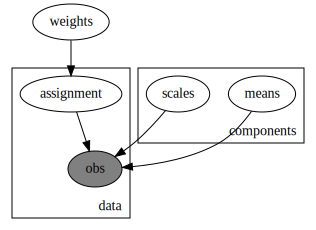

In [ ]:
def gmm_model(data):
    # Prior over the number of clusters
    K = 2

    # Prior over the mixing proportions
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))

    with pyro.plate('components', K):
        # Priors for the component means and standard deviations
        means = pyro.sample('means', dist.Normal(torch.zeros(K), 5.0 * torch.ones(K)))
        scales = pyro.sample('scales', dist.LogNormal(torch.zeros(K), 0.5 * torch.ones(K)))

    with pyro.plate('data', len(data)):
        # Mixture assignment for each data point
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        # Condition on the observed data
        pyro.sample('obs', dist.Normal(means[assignment], scales[assignment]), obs=data)
# Generate some data
true_weights = torch.tensor([0.3, 0.7])
true_means = torch.tensor([-1.0, 1.0])
true_scales = torch.tensor([0.5, 0.5])

n_data = 500
assignments = dist.Categorical(true_weights).sample((n_data,))
gmm_data = dist.Normal(true_means[assignments], true_scales[assignments]).sample()


# Now you can call your model with this data
pyro.render_model(gmm_model, model_args=(gmm_data,))


### 1.3 Hidden Markov Model

A Hidden Markov Model (HMM) is a statistical Markov model in which the system being modeled is assumed to be a Markov process with unobserved (hidden) states. HMMs are widely used in temporal pattern recognition such as speech, handwriting, gesture recognition, part-of-speech tagging, musical score following, partial discharges and bioinformatics.

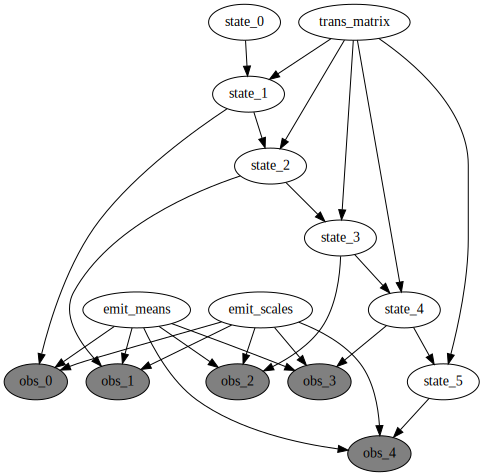

In [ ]:

def hmm_model(data):
    # Number of hidden states
    K = 2

    # Transition matrix
    trans_matrix = pyro.sample('trans_matrix', dist.Dirichlet(0.5 * torch.ones(K, K)))

    # Emission means and scales
    emit_means = pyro.sample('emit_means', dist.Normal(torch.zeros(K), 5.0 * torch.ones(K)))
    emit_scales = pyro.sample('emit_scales', dist.LogNormal(torch.zeros(K), 0.5 * torch.ones(K)))

    # Initial state
    state = pyro.sample('state_0', dist.Categorical(torch.ones(K) / K))

    for t in range(len(data)):
        state = pyro.sample(f'state_{t+1}', dist.Categorical(trans_matrix[state]), infer={"enumerate": "parallel"})
        pyro.sample(f'obs_{t}', dist.Normal(emit_means[state], emit_scales[state]), obs=data[t])


# Generate some data
true_trans_matrix = torch.tensor([[0.8, 0.2], [0.2, 0.8]])
true_emit_means = torch.tensor([-1.0, 1.0])
true_emit_scales = torch.tensor([0.5, 0.5])

n_data = 5
state = dist.Categorical(torch.ones(2) / 2).sample()
data = []
for _ in range(n_data):
    state = dist.Categorical(true_trans_matrix[state]).sample()
    data.append(dist.Normal(true_emit_means[state], true_emit_scales[state]).sample())

hmm_data = torch.stack(data)

# Now you can call your model with this data
pyro.render_model(hmm_model, model_args=(hmm_data,))


### 1.5 Factor Analysis and Principal component analysis




### 1.6 Chinease restaurant process & Dirichlet Mixture of Wishards
